# Software Vulnerability Detection using Deep Learning (Experiment Replication)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

## Pre-processing

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [9]:
import h5py
import pandas as pd

In [15]:
# 3 datasets available

data = h5py.File("VDISC_train.hdf5",'r')
#data = h5py.File("VDISC_validate.hdf5",'r')
#data = h5py.File("VDISC_test.hdf5",'r')

In [30]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Create a new dataframe from the HDF5 file

In [16]:
mydf = pd.DataFrame(list(data['functionSource']))

In [17]:
mydf['CWE-119']=list(data['CWE-119']); mydf['CWE-120']=list(data['CWE-120']); mydf['CWE-469']=list(data['CWE-469']); mydf['CWE-476']=list(data['CWE-476']); mydf['CWE-other']=list(data['CWE-other']) 

In [18]:
mydf.rename(columns={0:'functionSource'},inplace=True)

In [71]:
mydf.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


In [19]:
mydf.to_pickle("VDISC_train.pickle")
#mydf.to_pickle("VDISC_validate.pickle")
#mydf.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

### Importing processed datasets

In [66]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

In [4]:
### CONTINUE LATER

## Learning Phase

### Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorlfow version:  2.0.0
Eager mode:  True
GPU is available


### Setting static and global variables

In [2]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [3]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [39]:
train=pd.read_pickle("VDISC_train.pickle")
validate=pd.read_pickle("VDISC_validate.pickle")
test=pd.read_pickle("VDISC_test.pickle")

for dataset in [train,validate,test]:
    for col in range(1,6):
        dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})

# Create source code sdata for tokenization
x_all = train['functionSource']
x_all = x_all.append(validate['functionSource'])
x_all = x_all.append(test['functionSource'])

In [40]:
# Overview of the datasets
pd.value_counts(train.iloc[:,1])

0    1000185
1      19286
Name: CWE-119, dtype: int64

In [41]:
one = train[train.iloc[:,1]==1].index.values.astype(int)
zero = train[train.iloc[:,1]==0].index.values.astype(int)

### Tokenizing the source codes

In [42]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(x_all))
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))

Number of tokens:  1207818


In [43]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [44]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3908040),
 ('0', 2633095),
 ('return', 2182544),
 ('i', 1720280),
 ('1', 1483872),
 ('int', 1271988),
 ('null', 1222633),
 ('the', 990541),
 ('t', 917046),
 ('n', 892342)]

### Create sequence files from the tokens

In [45]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [46]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['functionSource'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [47]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['functionSource'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [48]:
# Example data
print('Train', pd.value_counts(train.iloc[:,1]))
print('\nTest', pd.value_counts(test.iloc[:,1]))
print('\nValidate', pd.value_counts(validate.iloc[:,1]))

Train 0    1000185
1      19286
Name: CWE-119, dtype: int64

Test 0    124967
1      2452
Name: CWE-119, dtype: int64

Validate 0    125057
1      2419
Name: CWE-119, dtype: int64


### One-Hot-Enconding (OHE) on the datasets

In [49]:
y_train=[]
y_test=[]
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [50]:
# Example data
pd.value_counts(y_test[0][:,1])

0    124967
1      2452
dtype: int64

### Model Definition (CNN with Gaussian Noise and 1 Output Split)

In [51]:
# Must use non-sequential model building to create branches in the output layer
model = tf.keras.Sequential(name="CNN")
model.add(tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    input_length = INPUT_SIZE))
model.add(tf.keras.layers.GaussianNoise(stddev=np.sqrt(0.01)))
model.add(tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool1D(pool_size=50))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 13)           130000    
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 500, 13)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 512)          60416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 512)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)      

### Tensorboard Callbacks

In [59]:
## Create TensorBoard callbacks

callbackdir= 'D:\\temp\\cb'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True, 
                         write_images=True)

tbCallback.set_model(model)
mld = 'model/model-epoch-100-{epoch:02d}-single.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="val_loss",
                                         save_best_only=True, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

### Model Training

In [ ]:
ceiling = 38572
history = model.fit(x = x_train[[*one,*zero[0:ceiling]],:],
          y = train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(),
          validation_data = (x_validate, validate.iloc[:,1].to_numpy()),
          epochs = 100,
          batch_size = 32,
          verbose =2,
          callbacks=[mcp,tbCallback])

with open('history/history-Epoch100-CNN-single', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

### Code to Continue Training (Optional)

In [ ]:
# Continue training for another 100 epochs

history200 = model.fit(x = x_train[[*one,*zero[0:ceiling]],:],
          y = train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(),
          validation_data = (x_validate, validate.iloc[:,1].to_numpy()),
          epochs = 31,
          batch_size = 32,
          verbose =2,
          callbacks=[mcp,tbCallback])

with open('history/history-Epoch200-CNN-single', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


### Model Evaluation using Training Set

In [61]:
# Load model
model = tf.keras.models.load_model("model/model-epoch-100-67-single.hdf5")

In [62]:
results = model.evaluate(x_train[[*one,*zero[0:ceiling]],:], train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), verbose=0, batch_size=128, )
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted = model.predict_classes(x_train[[*one,*zero[0:ceiling]],:])
    
print('\nConfusion Matrix')
#predicted = model.predict_classes(x_test)
confusion = sklearn.metrics.confusion_matrix(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)
print(confusion)

tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))

loss: 0.28662088297446825
accuracy: 0.9077742

Confusion Matrix
[[36556  2016]
 [ 3320 15966]]

TP: 15966
FP: 2016
TN: 36556
FN: 3320

Accuracy: 0.9077742058142348
Precision: 0.8878878878878879
Recall: 0.8278544021570051
F-measure: 0.8568208650853278


### Model Evaluation using Testing Set

In [63]:
## Test data

results = model.evaluate(x_test, test.iloc[:,1].to_numpy(), batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted = model.predict_classes(x_test)
confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,1].to_numpy(), y_pred=predicted)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss: 0.20756492847684108
accuracy: 0.94133526
[[117926   7041]
 [   434   2018]]

TP: 2018
FP: 7041
TN: 117926
FN: 434

Accuracy: 0.9413352796678675
Precision: 0.22276189424881335
Recall: 0.8230016313213703
F-measure: 0.35062114499174707


### Plot The Model's Training History

In [69]:
model.metrics_names

['loss', 'accuracy']

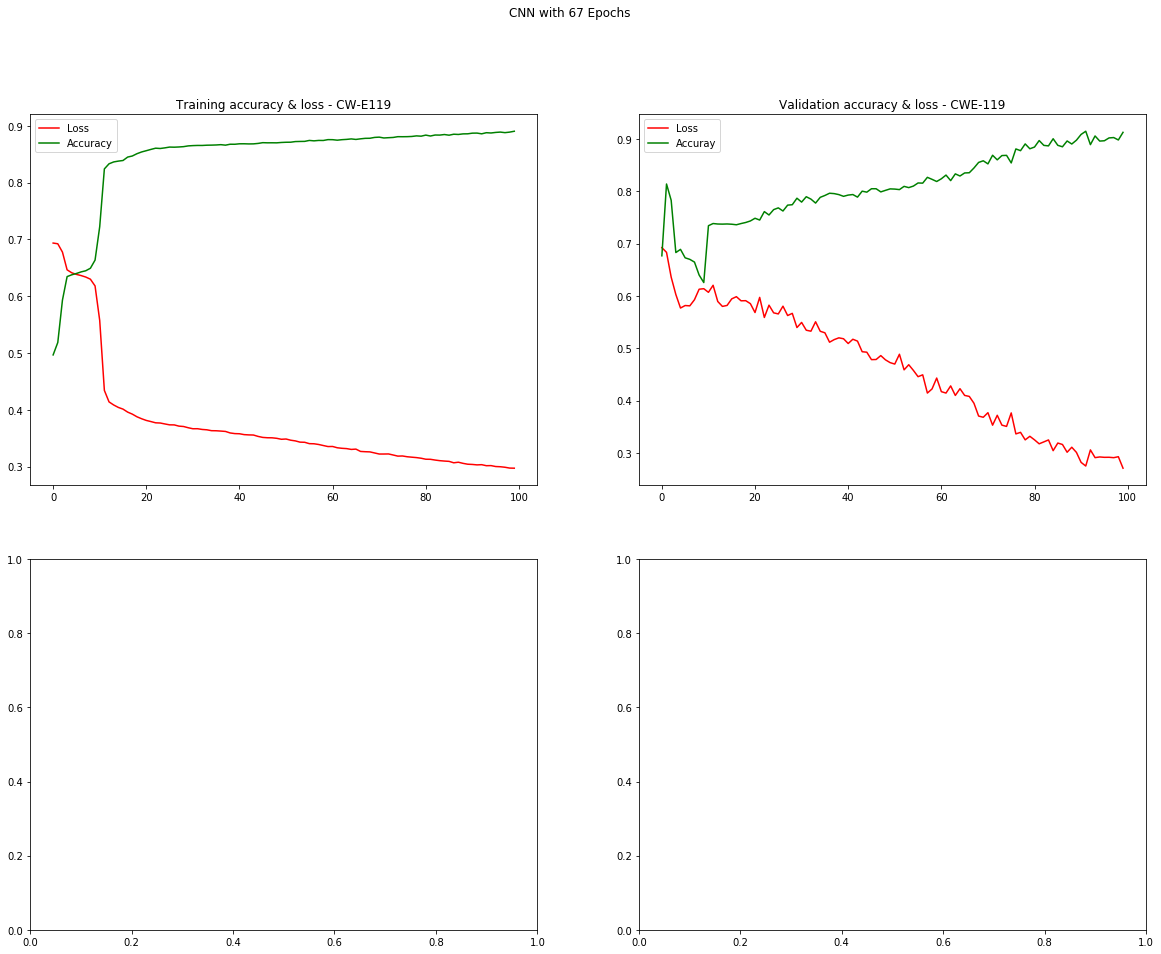

In [84]:
epochs_range = range(len(history.history[model.metrics_names[1]]))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
fig.suptitle('CNN with 67 Epochs')

axs[0,0].plot(epochs_range, history.history[model.metrics_names[0]], 'b', label='Loss', color='red')
axs[0,0].plot(epochs_range, history.history[model.metrics_names[1]], 'b', label='Accuracy', color='green')
axs[0,0].set_title('Training accuracy & loss - CW-E119')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[0])], 'b', label='Loss', color='red')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='Accuray', color='green')
axs[0,1].set_title('Validation accuracy & loss - CWE-119')
axs[0,1].legend()


